In [0]:
import tensorflow as tf
import os

from tensorflow.python.keras.datasets import cifar10
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.python.keras.utils import to_categorical

import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train.shape, X_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

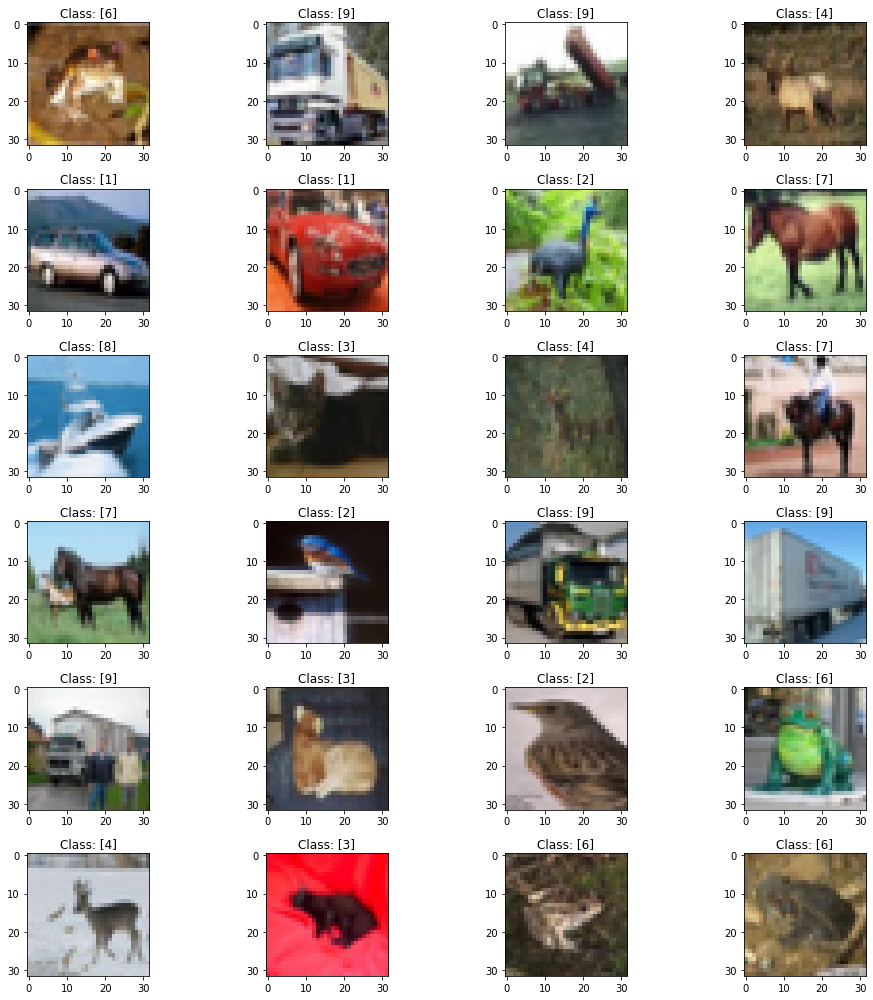

In [25]:
plt.figure(figsize=(14,14)) # bigger size of images

for idx in range(24):
    plt.subplot(6, 4, idx+1)
    plt.imshow(X_train[idx], cmap='gray')
    plt.title('Class: {}'.format(y_train[idx]))

plt.tight_layout() #increase the space between images

In [26]:
img_rows, img_cols = X_train.shape[1], X_train.shape[2]

num_channels = 3
X_train = X_train.reshape(-1, img_rows, img_cols, num_channels)
X_test = X_test.reshape(-1, img_rows, img_cols, num_channels)

input_shape = (img_rows, img_cols, num_channels)

X_train.shape, X_test.shape


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [0]:
if np.max(X_train) > 1: X_train = X_train /255
if np.max(X_test) > 1: X_test = X_test /255

In [28]:
X_test.max()

1.0

In [0]:
# because we want to have one dimension
if len(y_train.shape)==2:
  y_train = y_train.reshape(-1)
  y_test = y_test.reshape(-1)

# now we want to add number of classes
if len(y_train.shape) == 1:
    num_classes = len(set(y_train))
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

In [30]:
y_train.shape, y_test.shape, num_classes

((50000, 10), (10000, 10), 10)

In [31]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
    
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)         

In [0]:
model.fit(X_train, y_train,
          batch_size=256,
          epochs=10,
          verbose=2,
          validation_data=(X_test, y_test))

### We want to see the loss and accuracy 

In [12]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 110us/sample - loss: 0.8542 - acc: 0.7061


[0.8541889267921448, 0.7061]

### Let's go to TPU

In [0]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
model,
strategy=tf.contrib.tpu.TPUDistributionStrategy(
tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

In [0]:
tpu_model.fit(
    X_train, y_train,
    batch_size=128*8,
    epochs=20,
    validation_split=0.2
)

In [0]:
tpu_model.evaluate(X_test, y_test)